<a href="https://colab.research.google.com/github/alexandre-pinon/zoidberg-2.0/blob/main/zoidberg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zoidberg 2.0

**Given some X-ray images, use machine learning to help doctors detecting pneumonia.**

## Notebook Config

In [1]:
DATASET_DIR = "/content/zoidberg-2.0/chest_Xray_binary"
SEED = 2
IMG_SIZE = 224, 224
BATCH_SIZE = 32

In [2]:
import os
import pathlib
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data

In [3]:
!git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

Cloning into 'zoidberg-2.0'...
remote: Enumerating objects: 5910, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 5910 (delta 1), reused 8 (delta 1), pack-reused 5902
Receiving objects: 100% (5910/5910), 1.14 GiB | 13.97 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (11712/11712), done.


## Inspect data

In [4]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(DATASET_DIR):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/val'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_binary/val/pneumonia'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_binary/val/normal'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/train'.
There are 0 directories and 3875 images in '/content/zoidberg-2.0/chest_Xray_binary/train/pneumonia'.
There are 0 directories and 1341 images in '/content/zoidberg-2.0/chest_Xray_binary/train/normal'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/test'.
There are 0 directories and 390 images in '/content/zoidberg-2.0/chest_Xray_binary/test/pneumonia'.
There are 0 directories and 234 images in '/content/zoidberg-2.0/chest_Xray_binary/test/normal'.


In [4]:
train_dir = f"{DATASET_DIR}/train/"
val_dir = f"{DATASET_DIR}/val/"
test_dir = f"{DATASET_DIR}/test/"

In [5]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['normal' 'pneumonia']


In [6]:
def view_random_images(target_dir, class_names):
  n_images = 10
  fig, ax = plt.subplots(2, 5, figsize=(24, 8))

  # Read in the image and plot it using matplotlib
  for i in range(n_images):
    target_class = random.choice(class_names)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)[0]

    index = (0, i) if i < 5 else (1, i - 5)
    img = mpimg.imread(f'{target_folder}/{random_image}')
    ax[index].imshow(img, cmap='bone')
    ax[index].set_title(target_class)
    ax[index].set_frame_on(False)
    ax[index].set_xticks([])
    ax[index].set_yticks([])
    ax[index].set_xlabel(f"{img.shape}")

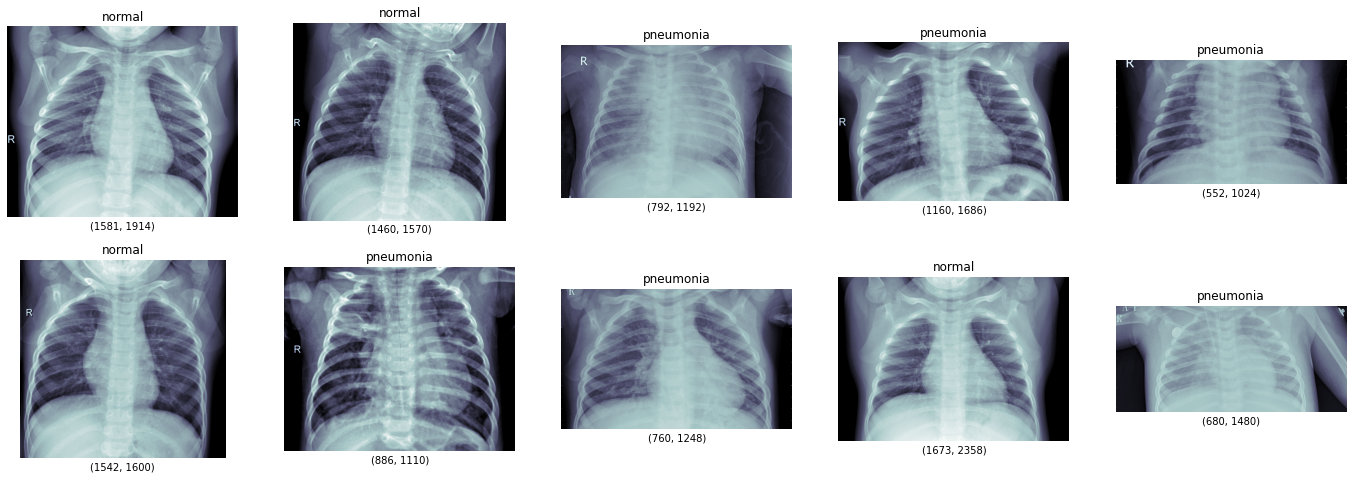

In [8]:
# View a random image from the training dataset
img = view_random_images(target_dir=train_dir,
                         class_names=class_names)

## Preprocess data

In [7]:
# Create train and test data generators and rescale the data 
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')

val_data = train_datagen.flow_from_directory(directory=train_dir,
                                           target_size=IMG_SIZE,
                                           class_mode='binary',
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           seed=SEED,
                                           subset='validation')

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='binary',
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Create baseline model

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_1 = Sequential([
  Flatten(input_shape=(*IMG_SIZE, 3)),
  Dense(4, activation='relu'),
  Dense(1, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 56s 422ms/step - loss: 0.6794 - accuracy: 0.7400 - val_loss: 0.6658 - val_accuracy: 0.7430
Epoch 2/5
131/131 [==============================] - 55s 418ms/step - loss: 0.6544 - accuracy: 0.7429 - val_loss: 0.6435 - val_accuracy: 0.7430
Epoch 3/5
131/131 [==============================] - 55s 418ms/step - loss: 0.6341 - accuracy: 0.7429 - val_loss: 0.6252 - val_accuracy: 0.7430
Epoch 4/5
131/131 [==============================] - 55s 420ms/step - loss: 0.6183 - accuracy: 0.7429 - val_loss: 0.6114 - val_accuracy: 0.7430
Epoch 5/5
131/131 [==============================] - 55s 422ms/step - loss: 0.6059 - accuracy: 0.7429 - val_loss: 0.6008 - val_accuracy: 0.7430


In [ ]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 150528)            0         
                                                                 
 dense_21 (Dense)            (None, 4)                 602116    
                                                                 
 dense_22 (Dense)            (None, 1)                 5         
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 602,123
Trainable params: 602,123
Non-trainable params: 0
_________________________________________________________________


## Evaluate model

In [9]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # Plot loss
  ax[0].plot(epochs, loss, label='training_loss', c='r')
  ax[0].plot(epochs, val_loss, label='val_loss', c='orange')
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].legend()

  # Plot accuracy
  ax[1].plot(epochs, accuracy, label='training_accuracy', c='g')
  ax[1].plot(epochs, val_accuracy, label='val_accuracy', c='lightgreen')
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].legend()

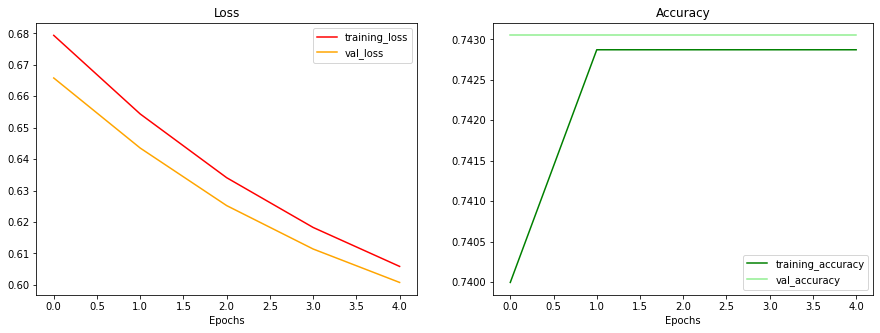

In [ ]:
plot_loss_curves(history_1)

In [10]:
def evaluate_model(model, test_data):
  loss, acc = model.evaluate(test_data, verbose=False)
  print(f'Model loss {loss:.1f}')
  print(f'Model accuracy {acc:.1%}')

In [ ]:
evaluate_model(model_1, test_data)

Model loss 0.7
Model accuracy 62.5%


## Adjust the model parameters

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_2 = Sequential([
  Flatten(input_shape=(*IMG_SIZE, 3)),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 56s 426ms/step - loss: 1.9145 - accuracy: 0.8088 - val_loss: 0.3562 - val_accuracy: 0.8754
Epoch 2/5
131/131 [==============================] - 54s 417ms/step - loss: 0.2811 - accuracy: 0.9058 - val_loss: 0.1864 - val_accuracy: 0.9348
Epoch 3/5
131/131 [==============================] - 55s 419ms/step - loss: 0.3014 - accuracy: 0.9104 - val_loss: 0.2078 - val_accuracy: 0.9271
Epoch 4/5
131/131 [==============================] - 55s 418ms/step - loss: 0.1824 - accuracy: 0.9384 - val_loss: 0.2621 - val_accuracy: 0.9003
Epoch 5/5
131/131 [==============================] - 55s 420ms/step - loss: 0.1318 - accuracy: 0.9521 - val_loss: 0.1645 - val_accuracy: 0.9358


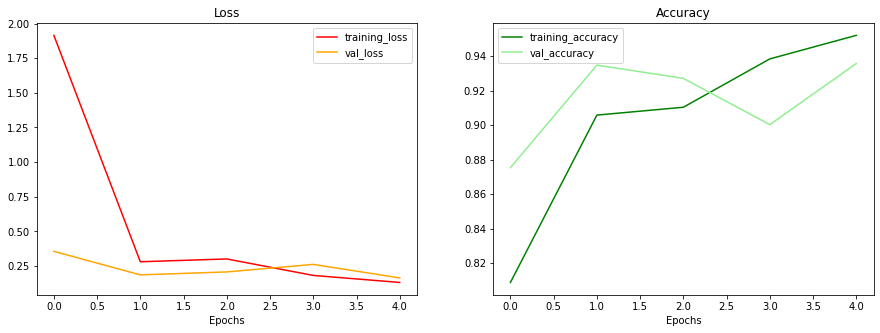

In [ ]:
plot_loss_curves(history_2)

In [ ]:
evaluate_model(model_2, test_data)

Model loss 0.7
Model accuracy 77.9%


## Making a prediction

In [22]:
def make_val_predictions(model, class_names):
  # Import the target images and preprocess them
  plot_datagen = ImageDataGenerator(rescale=1/255.)
  plot_data = plot_datagen.flow_from_directory(directory=val_dir,
                                                target_size=IMG_SIZE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                seed=SEED)
  # Make predictions
  preds = model.predict(plot_data).flatten()

  # Get predictions labels & percentages
  percentages = []
  preds_labels = []
  true_labels = class_names[plot_data.labels]

  for pred in preds:
    percentages.append(pred if pred >= 0.5 else 1 - pred)
    preds_labels.append(class_names[int(tf.round(pred))])

  img_paths = plot_data.filepaths
  n_images = len(preds)
  n_rows = n_cols = (n_images // 4)
  fig, axes = plt.subplots(n_rows,
                           n_cols,
                           figsize=(4 * n_cols, 3 * n_rows),
                           gridspec_kw={'wspace': 0, 'hspace': .6})
  axes = np.ravel(axes)

  for i, ax in enumerate(axes):
    if i == n_images:
      break

    img = mpimg.imread(img_paths[i])
    color = 'green' if preds_labels[i] == true_labels[i] else 'red'

    ax.imshow(img, cmap='bone')
    ax.set_title(f"Pred: {preds_labels[i]} {percentages[i]:.1%}\n(True: {true_labels[i]})", c=color)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

Found 16 images belonging to 2 classes.


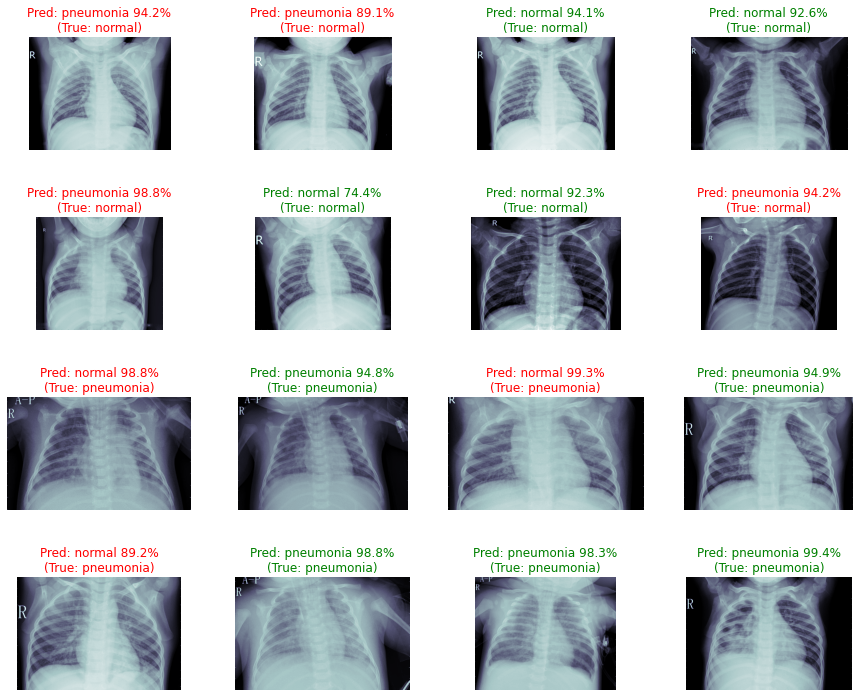

In [ ]:
make_val_predictions(model_2, class_names)

Found 16 images belonging to 2 classes.


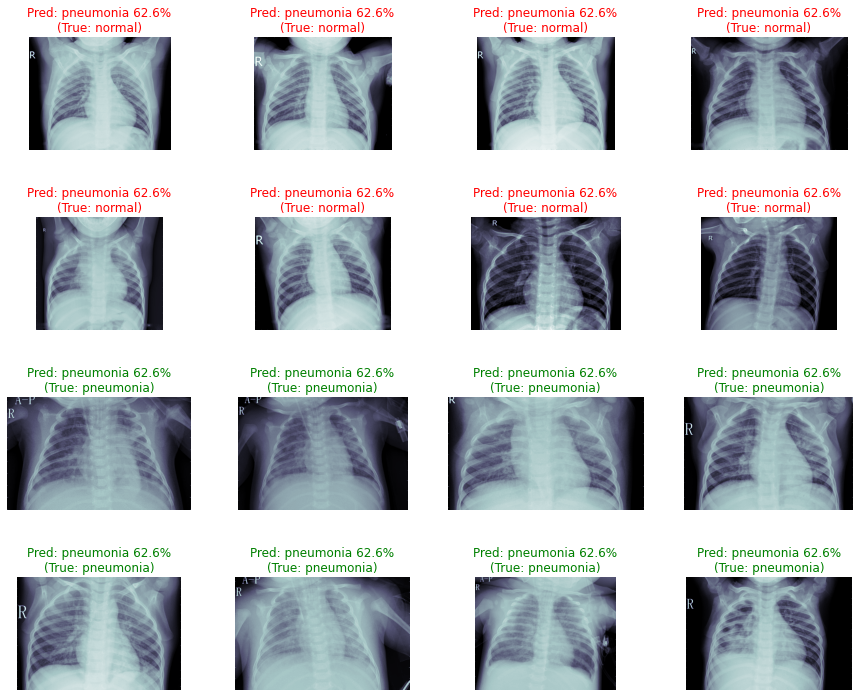

In [ ]:
make_val_predictions(model_1, class_names)

# CNN

In [14]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_3 = Sequential([
  Conv2D(filters=10, # filter is the number of sliding windows going accross the input (higher = more complex model)
         kernel_size=3, # the size of the window going accross an input
         strides=1, # the size of the step the sliding window takes accross an input
         padding='valid', # if "same", output shape is same as input shape, if "valid", output shape gets compressed
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

# Compile the model
model_3.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 78s 511ms/step - loss: 0.4269 - accuracy: 0.8905 - val_loss: 0.1553 - val_accuracy: 0.9329
Epoch 2/5
131/131 [==============================] - 62s 472ms/step - loss: 0.0829 - accuracy: 0.9700 - val_loss: 0.1135 - val_accuracy: 0.9588
Epoch 3/5
131/131 [==============================] - 61s 466ms/step - loss: 0.0416 - accuracy: 0.9851 - val_loss: 0.1798 - val_accuracy: 0.9415
Epoch 4/5
131/131 [==============================] - 62s 471ms/step - loss: 0.0443 - accuracy: 0.9847 - val_loss: 0.2092 - val_accuracy: 0.9377
Epoch 5/5
131/131 [==============================] - 63s 479ms/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.1885 - val_accuracy: 0.9549


Model loss 2.6
Model accuracy 72.4%
Found 16 images belonging to 2 classes.


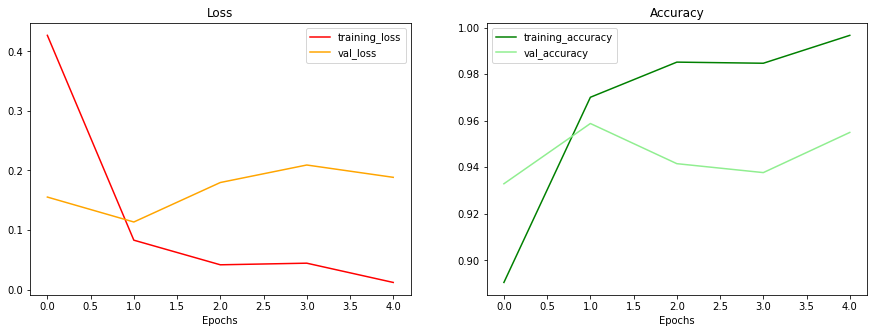

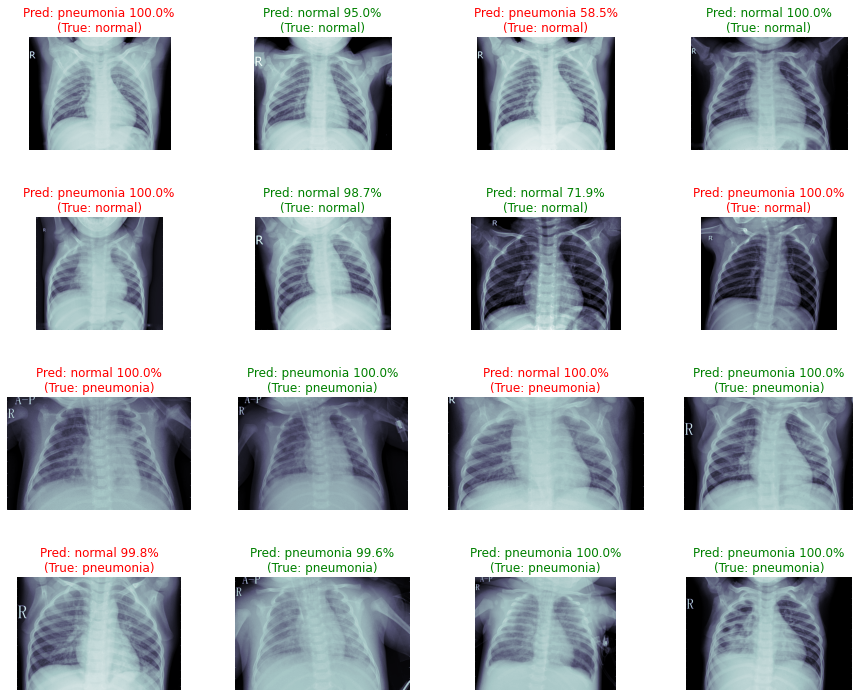

In [15]:
plot_loss_curves(history_3)
evaluate_model(model_3, test_data)
make_val_predictions(model_3, class_names)

## Tiny VGG

In [12]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 69s 446ms/step - loss: 0.3091 - accuracy: 0.8677 - val_loss: 0.1565 - val_accuracy: 0.9444
Epoch 2/5
131/131 [==============================] - 58s 442ms/step - loss: 0.1025 - accuracy: 0.9641 - val_loss: 0.1807 - val_accuracy: 0.9262
Epoch 3/5
131/131 [==============================] - 58s 442ms/step - loss: 0.0865 - accuracy: 0.9696 - val_loss: 0.1038 - val_accuracy: 0.9645
Epoch 4/5
131/131 [==============================] - 60s 461ms/step - loss: 0.0883 - accuracy: 0.9679 - val_loss: 0.1222 - val_accuracy: 0.9540
Epoch 5/5
131/131 [==============================] - 60s 455ms/step - loss: 0.0558 - accuracy: 0.9823 - val_loss: 0.1303 - val_accuracy: 0.9559


Model loss 1.0
Model accuracy 77.7%
Found 16 images belonging to 2 classes.


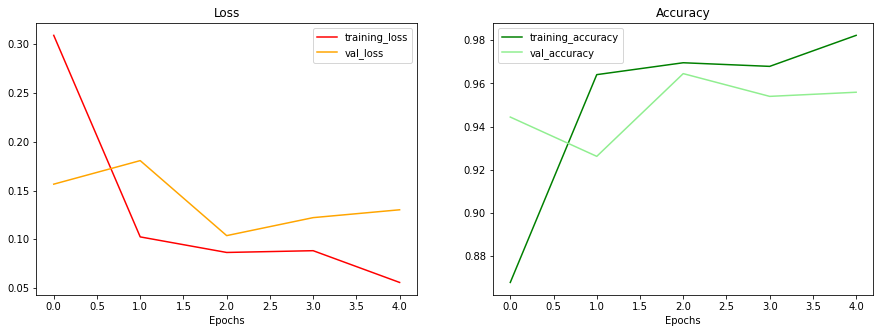

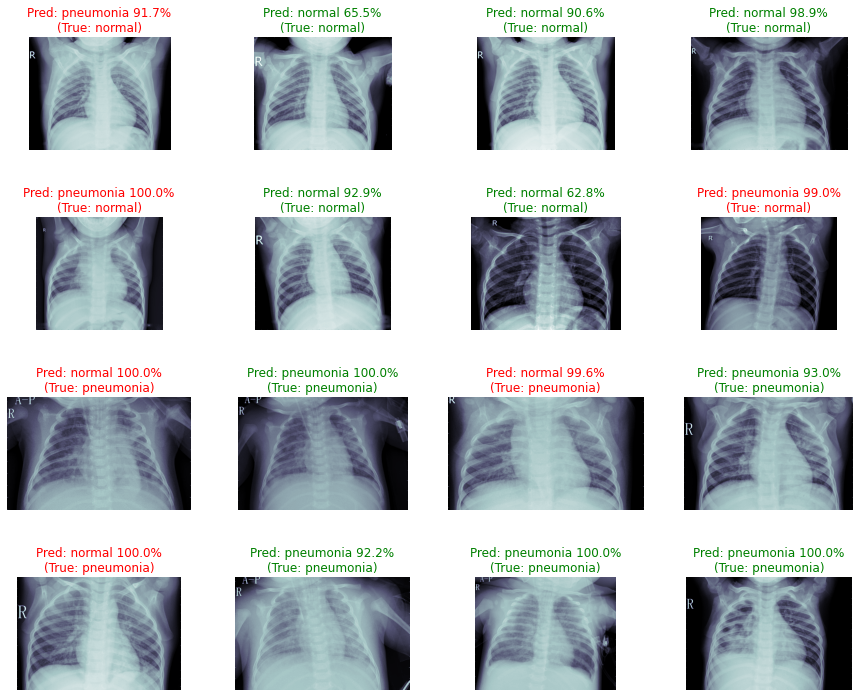

In [13]:
plot_loss_curves(history_4)
evaluate_model(model_4, test_data)
make_val_predictions(model_4, class_names)

In [14]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_5 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_5.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 69s 508ms/step - loss: 0.3068 - accuracy: 0.8711 - val_loss: 0.1531 - val_accuracy: 0.9348
Epoch 2/5
131/131 [==============================] - 63s 483ms/step - loss: 0.1474 - accuracy: 0.9437 - val_loss: 0.1760 - val_accuracy: 0.9300
Epoch 3/5
131/131 [==============================] - 65s 497ms/step - loss: 0.0853 - accuracy: 0.9693 - val_loss: 0.1808 - val_accuracy: 0.9377
Epoch 4/5
131/131 [==============================] - 65s 495ms/step - loss: 0.0781 - accuracy: 0.9700 - val_loss: 0.1221 - val_accuracy: 0.9473
Epoch 5/5
131/131 [==============================] - 65s 493ms/step - loss: 0.0654 - accuracy: 0.9763 - val_loss: 0.1084 - val_accuracy: 0.9569


Model loss 1.3
Model accuracy 74.0%
Found 16 images belonging to 2 classes.


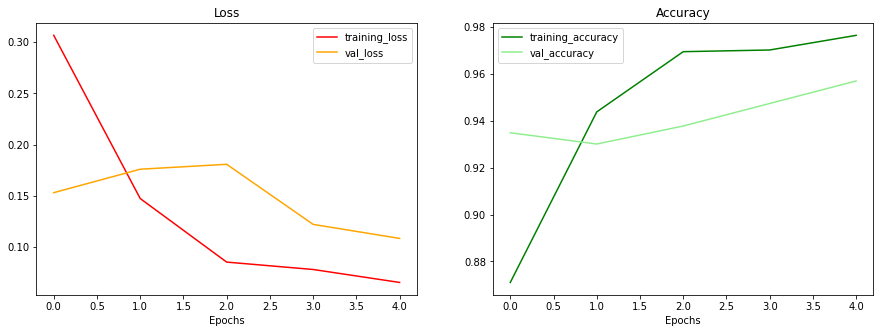

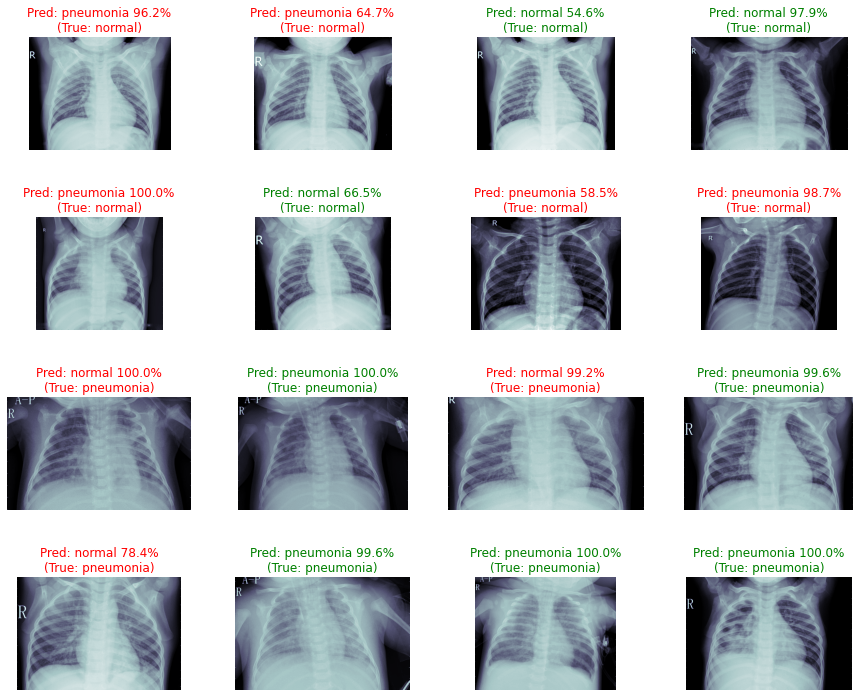

In [15]:
plot_loss_curves(history_5)
evaluate_model(model_5, test_data)
make_val_predictions(model_5, class_names)

In [16]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 61s 462ms/step - loss: 0.3815 - accuracy: 0.8370 - val_loss: 0.3109 - val_accuracy: 0.8725
Epoch 2/5
131/131 [==============================] - 62s 474ms/step - loss: 0.1405 - accuracy: 0.9451 - val_loss: 0.1485 - val_accuracy: 0.9444
Epoch 3/5
131/131 [==============================] - 60s 457ms/step - loss: 0.1087 - accuracy: 0.9590 - val_loss: 0.2184 - val_accuracy: 0.9185
Epoch 4/5
131/131 [==============================] - 59s 455ms/step - loss: 0.0900 - accuracy: 0.9672 - val_loss: 0.1427 - val_accuracy: 0.9425
Epoch 5/5
131/131 [==============================] - 59s 454ms/step - loss: 0.0807 - accuracy: 0.9710 - val_loss: 0.1209 - val_accuracy: 0.9521


Model loss 1.0
Model accuracy 74.0%
Found 16 images belonging to 2 classes.


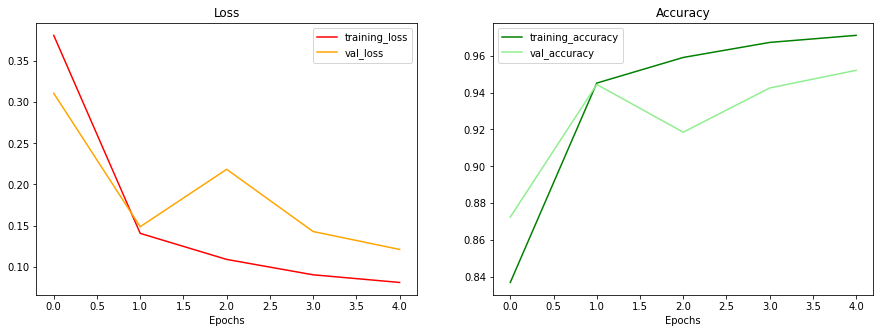

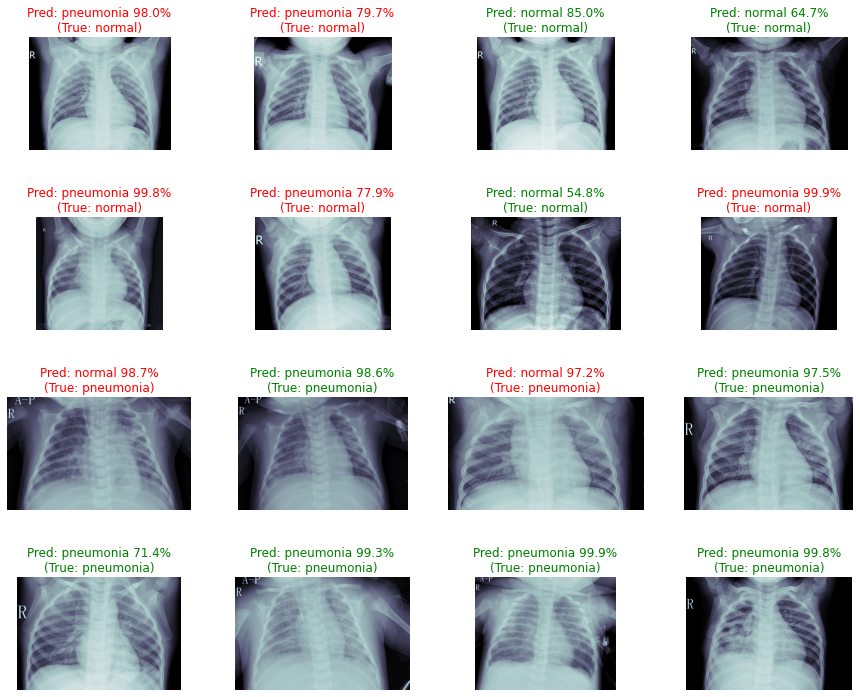

In [17]:
plot_loss_curves(history_6)
evaluate_model(model_6, test_data)
make_val_predictions(model_6, class_names)

In [29]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_7 = Sequential([
  Conv2D(100, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(100, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_7 = model_7.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 95s 713ms/step - loss: 0.3893 - accuracy: 0.8308 - val_loss: 0.2900 - val_accuracy: 0.8859
Epoch 2/5
131/131 [==============================] - 94s 715ms/step - loss: 0.1398 - accuracy: 0.9504 - val_loss: 0.1708 - val_accuracy: 0.9463
Epoch 3/5
131/131 [==============================] - 94s 716ms/step - loss: 0.0903 - accuracy: 0.9660 - val_loss: 0.1672 - val_accuracy: 0.9415
Epoch 4/5
131/131 [==============================] - 94s 715ms/step - loss: 0.0626 - accuracy: 0.9768 - val_loss: 0.1395 - val_accuracy: 0.9530
Epoch 5/5
131/131 [==============================] - 94s 714ms/step - loss: 0.0472 - accuracy: 0.9830 - val_loss: 0.1653 - val_accuracy: 0.9492


Model loss 1.5
Model accuracy 72.9%
Found 16 images belonging to 2 classes.


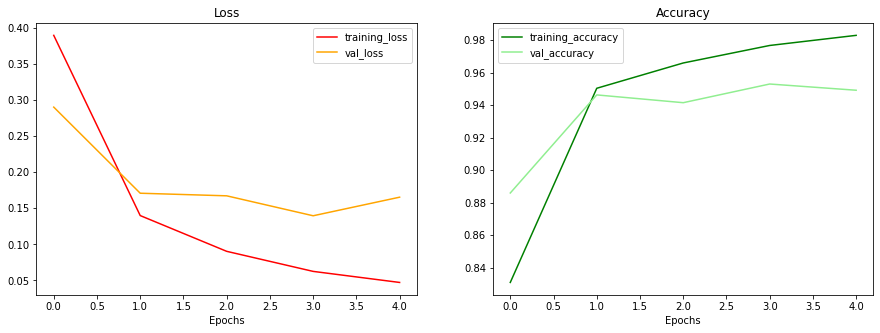

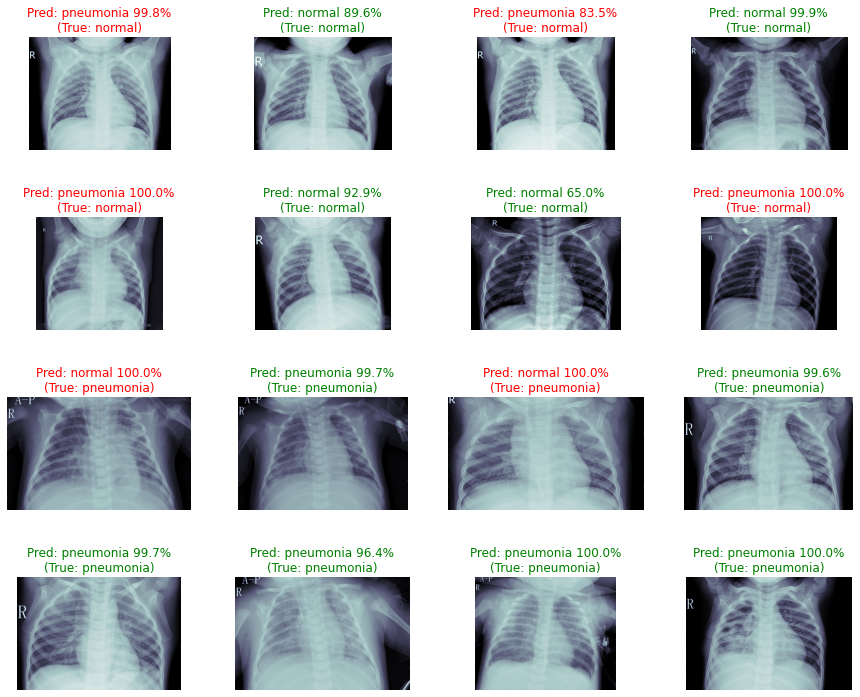

In [30]:
plot_loss_curves(history_7)
evaluate_model(model_7, test_data)
make_val_predictions(model_7, class_names)